# Chapter07 앙상블 학습과 랜덤 포레스트

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

- 앙상블 학습 (Ensemble Learning) :

 여러 개의 모델을 생성하고, 그 예측을 결합함으로써 보다 정확한 예측을 도출하는 기법

### 7.1 투표 기반 분류기

In [2]:
# 앞면이 51%, 뒷면이 49%가 나오는 동전 10,000번 던지는 실험을 10번을 함
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

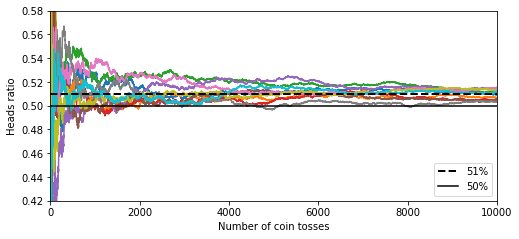

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

# 큰 수의 법칙 : 더 많이 던질수록 앞면이 다수가 될 확률이 증가한다

각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것 (직접 투표)

- 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘한다.

- 각기 다른 알고리즘으로 학습시킨다 --> 매우 다른 종류의 오차를 만들기 때문에 앙상블 모델의 정확도↑


In [4]:
# make_moons 데이터셋 불러오기
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
# 투표 기반 분류기 (VotingClassifier) 생성 후 훈련

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()      # 로지스틱 회귀
rnd_clf = RandomForestClassifier()  # 랜덤포레스트 분류기
svm_clf = SVC()
#svm_clf = SVC(probability=True)    # 클래스 확률 제공 (간접 투표 가능)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')  # voting='hard': 단순하게 가장 많은 투표를 받은 클래스를 voting 하는 방법
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [6]:
# 각 분류기의 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))   # 모델 이름, 정확도 출력

# 다른 개별 분류기보다 투표 기반 분류기가 성능이 조금 더 높다

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.904


- 직접 투표 (hard voting) : 단순하게 가장 많이 선택된 클래스를 예측

- 간접 투표 (soft voting) : 각 클래스에 대한 확률을 평균내어 가장 높은 클래스를 예측, 확률이 높은 투표에 비중을 더 둔다.

 (단, predict_proba() 메서드가 있어야 함)

 SVC에서는 클래스 확률을 제공하지 않으므로, probability=True로 지정해주어야 한다.

### 7.2 배깅과 페이스팅

배깅과 페이스팅

- **배깅 (bagging $or$ bootstrap aggregating)** : 훈련세트에서 중복을 허용하여 샘플링하는 방식

- **페이스팅 (pasting)** : 중복을 허용하지 않고 샘플링하는 방식

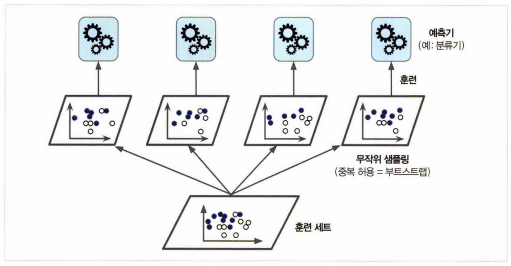

- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아 새로운 샘플에 대한 예측을 만든다.

- 일반적으로 앙상블의 결과는 개별 예측기와 비교하면 분산이 줄어든다.

위 그림처럼 예측기는 모두 동시에 다른 CPU 코어나 서버에서 병렬로 학습시킬 수 있다. (예측도 마찬가지)

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,  # n_estimators: 앙상블 시킬 모델 수
    max_samples=100, bootstrap=True, n_jobs=-1)  # max_samples: 선택할 샘플 수,  bootstrap: 중복 허용할지, 안할지
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [8]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(tree_clf.__class__.__name__, accuracy_score(y_test, y_pred_tree)) # 개별 결정트리 모델
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))       # 배깅 앙상블 모델

DecisionTreeClassifier 0.856
BaggingClassifier 0.912


In [9]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

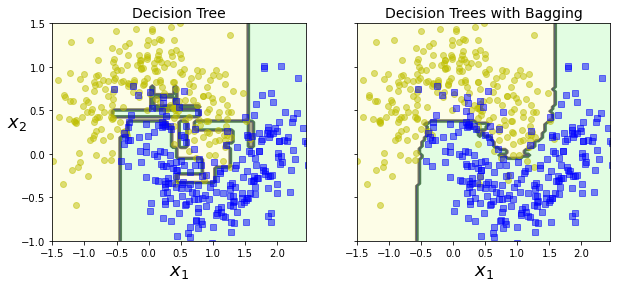

In [10]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)  # 단일 결정트리 모델의 결정경계
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)   # 배깅 앙상블 모델의 결정경계
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

- **oob** (out-of-bag) : 개별 모델을 훈련할 때, 선택되지 않은 훈련 샘플들

 oob 평가 : oob 샘플을 검증세트로 재활용한다.

In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_   # 앙상블 모델의 평가 점수 (각 예측기의 oob평가를 평균하여 얻는다)

0.904

In [12]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)  # 테스트세트에서의 실제 정확도

0.904

In [13]:
bag_clf.oob_decision_function_[:10] # oob 샘플에 대한 각 훈련 샘플의 클래스 확률 반환

array([[0.38918919, 0.61081081],
       [0.36180905, 0.63819095],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09836066, 0.90163934],
       [0.38285714, 0.61714286],
       [0.01156069, 0.98843931],
       [0.99462366, 0.00537634],
       [0.98453608, 0.01546392]])

### 7.3 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier는 특성 샘플링도 지원한다. (max_features, bootstrap_features로 조절)

- 랜덤 패치 방식 : 훈련 특성과 샘플을 모두 샘플링하는 것

- 랜덤 서브스페이스 방식 : 훈련 샘플을 모두 사용하고, 특성은 샘플링하는 것

 bootstrap=True, max_samples=1.0으로 설정, 

 bootstrap_features=True, 그리고/또는 max_features를 1.0보다 작게 설정

### 7.4 랜덤 포레스트

- **랜덤 포레스트** : 일반적으로 배깅 (또는 페이스팅) 방법을 적용한 결정 트리의 앙상블

 전형적으로 max_samples을 훈련 세트의 크기로 지정

In [14]:
# 최대 16개의 리프노드를 갖는 500개의 결정 트리로 이루어진 랜덤 포레스트 분류기 생성 후 훈련
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

**RandomForestClassifier**는 DecisionTreeClassifier의 매개변수와 BaggingClassifier의 매개변수를 거의 다 가지고 있다.

전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입한다.

In [15]:
# BaggingClassifier를 사용하여 앞의 RandomForestClassifier를 유사하게 만들어보자

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)

y_pred_bf = bag_clf.predict(X_test)

In [16]:
np.sum(y_pred_rf == y_pred_bf) / len(X_test)  # 예측이 거의 동일하다

0.976

- 엑스트라 트리 : 극단적으로 무작위한 트리의 랜덤 포레스트

 (보통의 결정트리처럼) 최적의 임곗값을 찾는 대신, 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택하는 방식

In [17]:
# 엑스트라 트리 모델
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
ext_clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=16, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [18]:
y_pred_ext = ext_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_ext))

0.92


랜덤 포레스트는 특성의 상대적 중요도를 측정하기 쉽다.

- 특성 중요도 :

 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성 중요도를 측정한다.

 중요도의 전체 합이 1이 되도록 정규화하여 feature_importances_ 변수에 저장된다.

랜덤 포레스트는 특히 특성을 선택해야 할 때 어떤 특성이 중요한지 빠르게 확인할 수 있다.

In [19]:
# 특성 중요도
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(f"{name:<18} {score}")

sepal length (cm)  0.11249225099876375
sepal width (cm)   0.02311928828251033
petal length (cm)  0.4410304643639577
petal width (cm)   0.4233579963547682


In [20]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

In [21]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [22]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [23]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

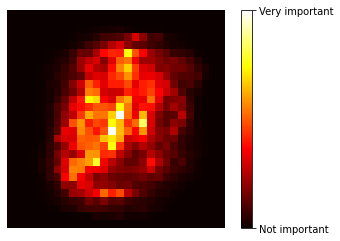

In [24]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

MNIST 데이터셋에 랜덤 포레스트 분류기를 훈련시켜 각 픽셀의 중요도를 그래프로 나타낸 이미지

### 7.5 부스팅

**부스팅** : 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법

--> 앞의 모델을 보완해나가면서 일련의 에측기를 학습시킨다.

- 에이다부스트 : 

 1. 이전 모델이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 더 높인다.

 2. 업데이트된 가중치를 사용해 다음 모델이 훈련하여 다시 예측을 만든다.

 3. 다시 가중치 업데이트 후 반복한다.

 이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다.

In [25]:
# 에이다부스트
from sklearn.ensemble import AdaBoostClassifier

# 깊이가 1인 결정트리 200개를 사용한 에이다부스트
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

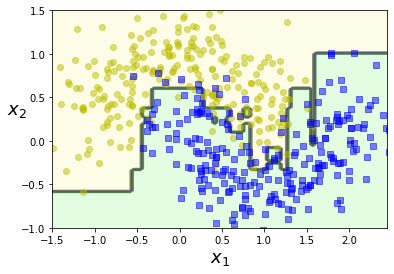

In [26]:
plot_decision_boundary(ada_clf, X, y)

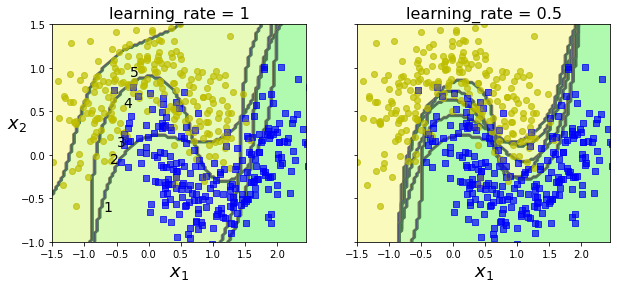

In [27]:
# 연속된 예측기의 결정 경계

m = len(X_train)  # 샘플 수

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m     # 샘플의 가중치
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # [식 7-1]
        alpha = learning_rate * np.log((1 - r) / r)        # [식 7-2]
        sample_weights[y_pred != y_train] *= np.exp(alpha) # [식 7-3]
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

에이다 부스트 알고리즘

1. $j$번째 예측기의 가중치가 적용된 에러율 계산

 [ 식 7-1 ] : $r_j = \frac{\hat{y}^{(i)}_j \neq y^{(i)}}{\displaystyle\sum^m_{i=1}w^{(i)}}\space\space$ ($\hat{y}^{(i)}_j : i$번째 샘플에 대한 $j$번째 예측기의 예측)

 --> 잘못 예측한 것들에 대한 가중치 / 전체 가중치 합 ( 0 ~ 1 사이의 값 )

2. 가중치 계산

 [ 식 7-2 ] : $\alpha_j = \eta \space log \frac{1-r_j}{r_j}$

 --> 예측기가 정확할수록 가중치가 더 높아지게 된다.

 무작위로 예측하면 가중치가 0에 가까울 것이다.

3. 가중치 업데이트

 [ 식 7-3 ] : $\Bigg\{
\begin{aligned}
w^{(i)} & & (\hat{y_j}^{(i)} = y^{(i)})일\space 때\\
w^{(i)} & exp(\alpha_j) & (\hat{y_j}^{(i)} \neq y^{(i)}) 일\space 때
\end{aligned}$

 즉, 잘못 분류된 가중치가 증가한다.

4. 모든 샘플의 가중치를 정규화

 즉, $\displaystyle\sum^m_{i=1}w^{(i)}$로 나눈다.

5. 에이다부스트 예측

 [ 식 7-4 ] : $\hat{y}(x) = argmax \displaystyle\sum_{i=1}^N \alpha_j$

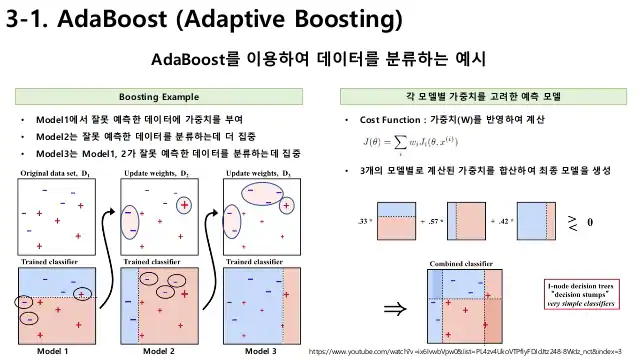

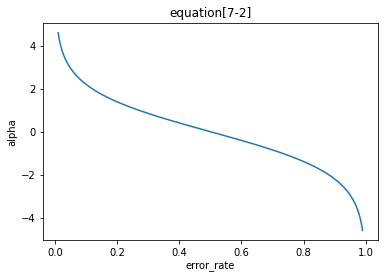

In [49]:
# 식 7-2 그래프
x = np.linspace(0.01,0.99, 1000)
y = np.log((1-x)/x)
plt.plot(x,y)
plt.xlabel('error_rate')
plt.ylabel('alpha')
plt.title('equation[7-2]')
plt.show()

- 그레이디언트 부스팅 :

 이전 예측기가 만든 잔여 오차 (residual error)에 새로운 예측기를 학습시킨다.


In [91]:
# 잡음이 섞인 2차 곡선 형태의 훈련세트 생성
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

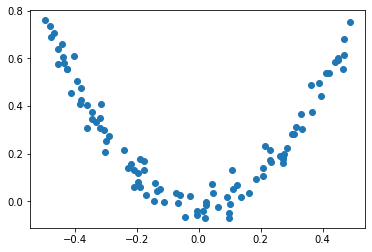

In [92]:
plt.scatter(X, y)
plt.show()

In [93]:
from sklearn.tree import DecisionTreeRegressor

# 첫 번째 예측기
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [95]:
y2 = y - tree_reg1.predict(X)   # 첫 번째 예측기가 만든 잔여 오차
# 두 번째 예측기
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)    # 잔여 오차에 대해 학습

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [98]:
y3 = y2 - tree_reg2.predict(X)  # 두 번째 예측기가 만든 잔여 오차
# 세 번째 예측기
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)    # 잔여 오차에 대해 학습

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [109]:
X_new = np.array([[0.5]])
# 세 개의 트리를 더한 앙상블 모델
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [110]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

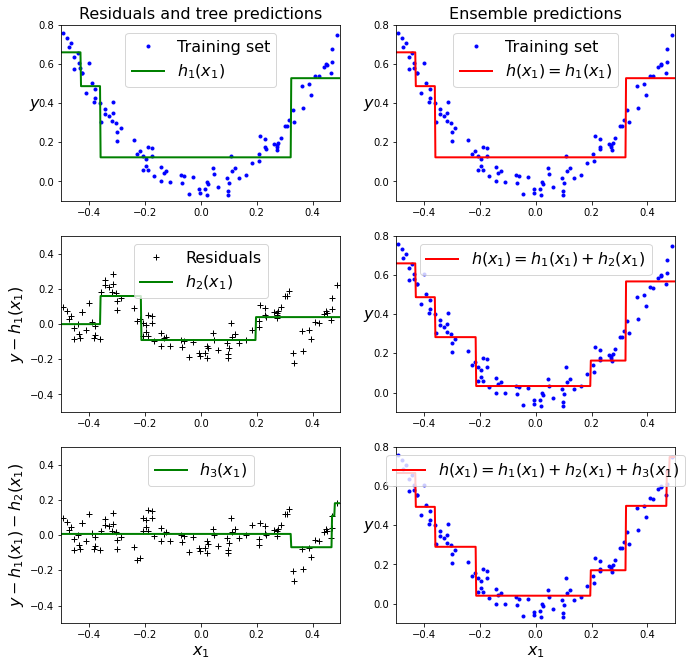

In [111]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.show()

왼쪽 열은 세 결정 트리의 예측이고 오른쪽 열은 앙상블(트리를 더한 것)의 예측이다.

- 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아진다!

In [112]:
# 이전에 만든 것과 같은 앙상블을 만드는 코드
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
# learning_rate: 각 트리의 기여 정도를 조절
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [115]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

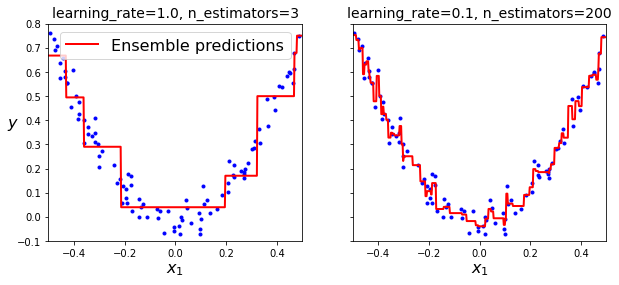

In [116]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

# learning_rate=1.0, n_estimators=3인 그레이디언트 부스팅 모델
plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

# learning_rate=0.1, n_estimators=200인 그레이디언트 부스팅 모델
plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.show()

왼쪽은 과소적합, 오른쪽은 과대적합되었다.

- 최적의 트리 수를 찾기 위해서 조기종료 기법을 사용할 수 있다

 staged_predict( ) 메서드를 이용해 최적의 트리 수를 구할 수 있다.

In [118]:
# 검증 오차를 계산해서 최적의 트리 수 찾아내기

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)
errors = [mean_squared_error(y_val, y_pred)     # 검증 오차
          for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors) + 1  # 최적의 트리 수

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=43,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

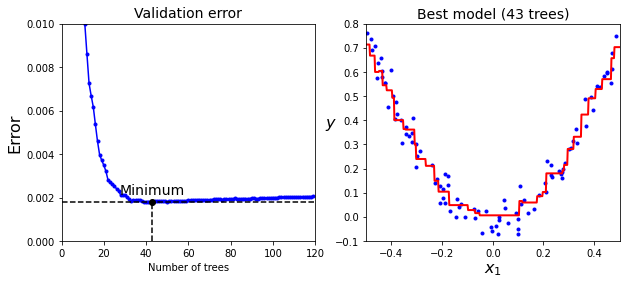

In [121]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % best_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)
plt.show()

In [122]:
# 연속해서 5번 동안 검증 오차가 향상되지 않으면 훈련을 멈추게 하는 코드

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [124]:
print(gbrt.n_estimators)
best_n_estimators = gbrt.n_estimators - error_going_up
best_n_estimators

48


43

- 확률적 그레이디언트 부스팅 :

 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정하여 훈련하는 것

 편향이 높아지는 대신, 분산이 낮아지게 되며, 훈련 속도를 상당히 높인다.

XGBoost ( extreme gradient boosting ) : 

최적화된 그레이디언트 부스팅 모델

In [129]:
# XGBoost 사용하기
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

[06:48:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0019881211570744357


In [130]:
# 자동 조기 종료 사용
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

[06:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.259401
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.233849
[2]	validation_0-rmse:0.212363
[3]	validation_0-rmse:0.191957
[4]	validation_0-rmse:0.17406
[5]	validation_0-rmse:0.157441
[6]	validation_0-rmse:0.143523
[7]	validation_0-rmse:0.130015
[8]	validation_0-rmse:0.118507
[9]	validation_0-rmse:0.107719
[10]	validation_0-rmse:0.098138
[11]	validation_0-rmse:0.089601
[12]	validation_0-rmse:0.083527
[13]	validation_0-rmse:0.078022
[14]	validation_0-rmse:0.072592
[15]	validation_0-rmse:0.067649
[16]	validation_0-rmse:0.063529
[17]	validation_0-rmse:0.059836
[18]	validation_0-rmse:0.056838
[19]	validation_0-rmse:0.053824
[20]	validation_0-rmse:0.051651
[21]	validation_0-rmse:0.049584
[22]	validation_0-rmse:0.047634
[23]	validation_0-rmse:0.046265
[24]	validation_0-rmse:0.04553
[25]	validation_0-rms

### 7.6 스태킹